# Part I, Build Model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

# save models to pickle
import pickle

In [4]:
path = 'kaggle_data/'
toxic_data = pd.read_csv(path + 'train.csv')
print('Number of rows and columns in the toxic data set:', toxic_data.shape)

Number of rows and columns in the toxic data set: (159571, 8)


In [5]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
# split toxic_data into train and test
train = toxic_data[:int(len(toxic_data)*0.7)]
test = toxic_data[int(len(toxic_data)*0.7):]

### Visualize variables

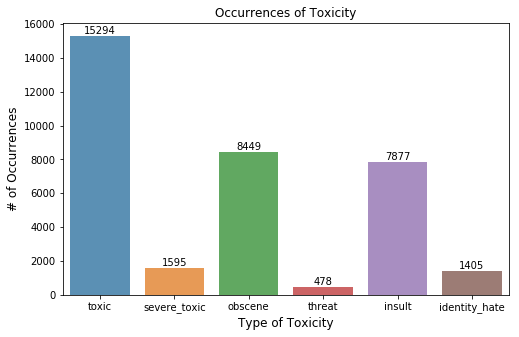

In [7]:
x = toxic_data.iloc[:, 2:].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('Occurrences of Toxicity')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type of Toxicity', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

### Vectorizers

In [8]:
all_text = toxic_data['comment_text']

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train['comment_text'])
test_word_features = word_vectorizer.transform(test['comment_text'])

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train['comment_text'])
test_char_features = char_vectorizer.transform(test['comment_text'])

In [ ]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

### Train & Score Models

In [18]:
models = {}
scores = []

for col in target_columns:
    train_target = train[col]
    classifier = LogisticRegression(C = 20, class_weight = 'balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for {} is {}'.format(col, cv_score))

    classifier.fit(train_features, train_target)
    print('Building model for column: {}'.format(col))
    models[col] = classifier
    
print('Total CV score is {}'.format(np.mean(scores)))

CV score for toxic is 0.968484851728307
Building model for column: toxic
CV score for severe_toxic is 0.9765443269312041
Building model for column: severe_toxic
CV score for obscene is 0.9839643269042049
Building model for column: obscene
CV score for threat is 0.9822257685846486
Building model for column: threat
CV score for insult is 0.9710518467189982
Building model for column: insult
CV score for identity_hate is 0.969811945884563
Building model for column: identity_hate
Total CV score is 0.9753471777919875


In [20]:
for col in target_columns:
    filename = 'model_{}.sav'.format(col)
    pickle.dump(models[col], open(filename, 'wb'))

In [21]:
filename = 'model_toxic.sav'
loaded_model = pickle.load(open(filename, 'rb'))

# Part 2, Predict Tweet Toxicity

In [9]:
df = pd.read_csv("twitter_data/st_daca_0117_0218", encoding = "ISO-8859-1",
                 usecols = ['date', 'fullname', 'id', 'likes', 'replies', 
                            'retweets', 'text', 'url', 'user', 'month'])

In [10]:
df.head()

,date,fullname,id,likes,replies,retweets,text,url,user,month
0,2017-09-22 23:59:53,Jose,911379557739106305,0,0,0,Luther Strange Hides from DACA Amnesty Questio...,/JoseD89344985/status/911379557739106305,JoseD89344985,2017-09-01
1,2017-09-22 23:59:48,Step Up Louisiana,911379534578094081,1,0,0,Protect #DACA and #TPS. #NoBanNoWall,/StepUpLA/status/911379534578094081,StepUpLA,2017-09-01
2,2017-09-22 23:59:20,It's ok to be white,911379416269201408,0,0,0,Please don't end DACA we need more people like...,/Perspec16977759/status/911379416269201408,Perspec16977759,2017-09-01
3,2017-09-22 23:58:41,ale,911379256218763264,9,0,5,#DREAMERS in utah go to http://diversity.utah....,/flazedas/status/911379256218763264,flazedas,2017-09-01
4,2017-09-22 23:58:37,#DefendDACA Â âï¸Â ðºð¸,911379237982089217,2,0,0,Repealing DACA Will Have Big Consequences for ...,/defenddacatx/status/911379237982089217,defenddacatx,2017-09-01


In [11]:
df['text'] = df['text'].apply(str)

In [12]:
df['text'].dtype

dtype('O')

### Vectorize tweets and predict toxicity with model

In [13]:
tweet_word_features = word_vectorizer.transform(df['text'])
tweet_char_features = char_vectorizer.transform(df['text'])
tweet_features = hstack([tweet_word_features, tweet_char_features])

NameError: name 'word_vectorizer' is not defined

In [296]:
tweet_features

<758x53605 sparse matrix of type '<class 'numpy.float64'>'
	with 293624 stored elements in COOrdinate format>

In [298]:
#for col in target_columns:

df['toxic'] = models['toxic'].predict_proba(tweet_features)[:, 1]

ValueError: X has 53605 features per sample; expecting 60000

In [288]:
df['classification'] = df[target_columns].idxmax(axis=1)

KeyError: "['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate'] not in index"

In [105]:
df.head()

,date,fullname,id,likes,replies,retweets,text,url,user,month,toxic,severe_toxic,obscene,threat,insult,identity_hate,classification
0,2017-10-25 23:59:52,Dedi Fredericks,923338352975327232,0,0,0,Undercover informant cleared to testify on #Ur...,/DediFredericks/status/923338352975327232,DediFredericks,2017-10-01,0.035030,0.001156,0.000302,0.000029,0.000019,0.000054,toxic
1,2017-10-25 23:59:50,I Support DJT,923338342112137221,11,1,5,GAG order for FBI Agent involved in Uranium on...,/JefmacMck/status/923338342112137221,JefmacMck,2017-10-01,0.022869,0.000194,0.000345,0.000052,0.000646,0.000150,toxic
2,2017-10-25 23:59:49,Sal Of The EarthÂ ð,923338339402616833,0,0,0,@DOJ LIFTS GAG ORDER ON #URANIUMONE INFORMANT....,/11SBiase/status/923338339402616833,11SBiase,2017-10-01,0.004953,0.000478,0.000188,0.000296,0.000071,0.000098,toxic
3,2017-10-25 23:59:49,M Helm,923338338916098048,0,0,0,Grassley: Bring in a Special Counsel to Invest...,/1Bunny4T/status/923338338916098048,1Bunny4T,2017-10-01,0.005757,0.000268,0.000105,0.000039,0.000123,0.000018,toxic
4,2017-10-25 23:59:47,Beth Donahue,923338331878027269,0,0,0,"MJ producers move on Uranium one, fbi informan...",/BethDonah/status/923338331878027269,BethDonah,2017-10-01,0.076094,0.001707,0.000376,0.000040,0.001468,0.000212,toxic


In [106]:
# export df
df.to_csv("classified_tweets_")

### Visualizations

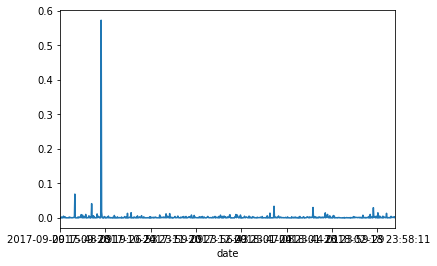

In [107]:
# visualize obscenity
df.groupby('date')['obscene'].mean().plot()

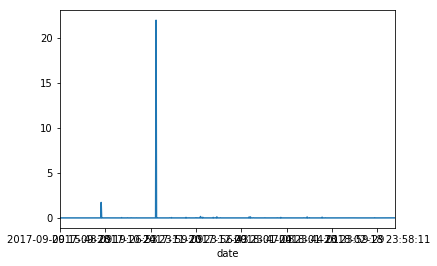

In [108]:
df['likes'] = df['likes'].astype(float)

# normalizing identity hate by tweet popularity
df['popular_obscene'] = df['obscene']*df['likes']
df.groupby('date')['popular_obscene'].mean().plot()

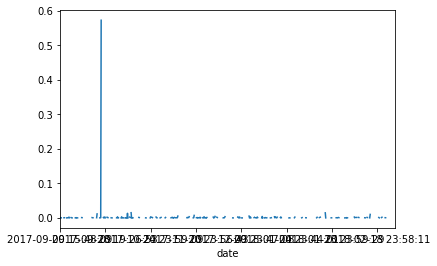

In [109]:
# normalizing identity hate by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].sum()).plot()

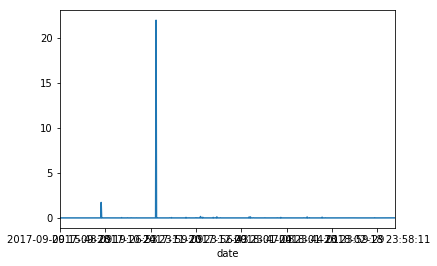

In [110]:
# normalizing popular tweets by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].count()).plot()

In [238]:
df['text'] = df['text'].apply(str)


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class